<a href="https://colab.research.google.com/github/menahilbak502/Predicting_Bechdel_Test_Outcomes/blob/main/Copy_of_DS110_FinalProject_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files

uploaded = files.upload() # upload movies.csv from kaggle

Saving movies.csv to movies.csv


In [ ]:
import pandas as pd
df = pd.read_csv('movies.csv', index_col = 'title')

In [ ]:

# remove films with "dubious" scores
movies = df[(df['year'].notna()) & (df['bt_score'].notna()) & (df['dubious'] == 0)].copy()

# returns True if the score is a passing score (3)
def pass_fail(score):
  if score == 3:
    return True
  return False

# returns True if the year is before 1960
def before_1960(year):
  if year < 1960:
    return True
  return False

# change bt_score and year columns into booleans
movies.loc[:, 'bt_score'] = movies['bt_score'].apply(pass_fail)
movies.loc[:, 'year'] = movies['year'].apply(before_1960)

In [ ]:
import scipy.stats
import numpy as np

# chi-square test
contingency = pd.crosstab(movies['bt_score'], movies['year'])
_, p, _, _ = scipy.stats.chi2_contingency(contingency)

print("the p-value is " + str(p) + '\n')
if p < 0.05:
  print("there is a significant relationship between whether or not a film passes the Bechdel Test and whether it was released before or after 1960.\n")
else:
  print("there is not a significant relationship between whether or not a film passes the Bechdel Test and whether it was released before or after 1960.\n")

# correlations
corr = scipy.stats.linregress(df['bt_score'], df['year'])
print("the r-value " + str(corr.rvalue) + " indicates a weak positive correlation between production year and Bechdel Test score")

the p-value is 1.3922935219895282e-12

there is a significant relationship between whether or not a film passes the Bechdel Test and whether it was released before or after 1960.
the r-value 0.16685214353290134 indicates a weak positive correlation between production year and Bechdel Test score


In [ ]:


from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# decision tree
def half_centuries(year):
  if year < 1900:
    return 1850
  elif year < 1950:
    return 1900
  elif year < 2000:
    return 1950
  elif year < 2050:
    return 2000

year_categories = df['year'].apply(half_centuries)

score_train0, score_test, year_train0, year_test = train_test_split(df[['bt_score', 'popularity', 'cast_female_representation', 'crew_female_representation']],
                                                   year_categories, random_state=42, shuffle=True)
score_train, score_val, year_train, year_val = train_test_split(score_train0, year_train0, random_state = 42, shuffle=True)

max_acc = 0
criteria = ["entropy", "gini", "log_loss"]
all_acc = []
for i in criteria:
  for j in range(4):
    dtree = DecisionTreeClassifier(criterion=i, max_depth=j+1, random_state=42)
    dtree.fit(score_train, year_train)
    acc = dtree.score(score_val, year_val)
    all_acc.append((i, j+1, acc))
    if acc > max_acc:
      max_acc = acc
      best_dtree = dtree
      best_criteria = i
      best_maxdepth = j+1

final_acc = best_dtree.score(score_test, year_test)

print("the best decision tree conditions are:\ncriteria = " + best_criteria + "\nmax depth = " + str(best_maxdepth) + "\nthis results in an accuracy score of " + str(final_acc))
print("the following is a record of the accuracy score for each case based on validation data:\n" + str(all_acc))

the best decision tree conditions are:
criteria = gini
max depth = 3
this results in an accuracy score of 0.6043956043956044
the following is a record of the accuracy score for each case based on validation data:
[('entropy', 1, 0.5743589743589743), ('entropy', 2, 0.5963369963369963), ('entropy', 3, 0.5963369963369963), ('entropy', 4, 0.5978021978021978), ('gini', 1, 0.5743589743589743), ('gini', 2, 0.5956043956043956), ('gini', 3, 0.6029304029304029), ('gini', 4, 0.6014652014652014), ('log_loss', 1, 0.5743589743589743), ('log_loss', 2, 0.5963369963369963), ('log_loss', 3, 0.5963369963369963), ('log_loss', 4, 0.5978021978021978)]


0.01385807193601929
the best linear regression model is made with two parameters, and the R^2 value is 0.018894511912945333


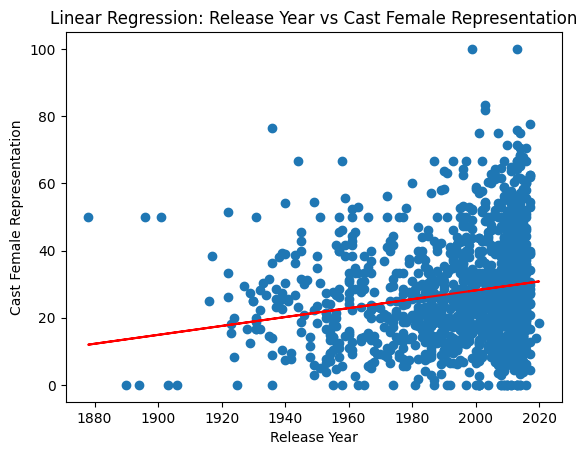

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt


x1 = df['year']
y = df['cast_female_representation']

x1_train0, x1_test, y_train0, y_test = train_test_split(x1, y, random_state=42)
x1_train, x1_val, y_train, y_val = train_test_split(x1_train0, y_train0, random_state=42)

x1_train = np.array(x1_train).reshape(-1, 1)
x1_val = np.array(x1_val).reshape(-1, 1)

linear_model = LinearRegression()
linear_model.fit(x1_train, y_train)
linear_r2score = linear_model.score(x1_val, y_val)

y_hat = linear_model.predict(x1_val)
plt.plot(x1_val, y_val, 'o')
plt.plot(x1_val, y_hat, 'r')
plt.title('Linear Regression: Release Year vs Cast Female Representation')
plt.xlabel('Release Year')
plt.ylabel('Cast Female Representation')

# multiple regression - Ava
x2 = np.array(df[['year', 'popularity']])

x2_train0, x2_test, y_train0, y_test = train_test_split(x2, y, random_state=42)
x2_train, x2_val, y_train, y_val = train_test_split(x2_train0, y_train0, random_state=42)

mult_model = LinearRegression()
mult_model.fit(x2_train, y_train)
mult_r2score = mult_model.score(x2_val, y_val)

if linear_r2score > mult_r2score:
  best_model = "one parameter"
  final_r2score = linear_model.score(x1_test, y_test)
else:
  best_model = "two parameters"
  final_r2score = mult_model.score(x2_test, y_test)
print(linear_r2score)
print("the best linear regression model is made with " + best_model + ", and the R^2 value is " + str(final_r2score))

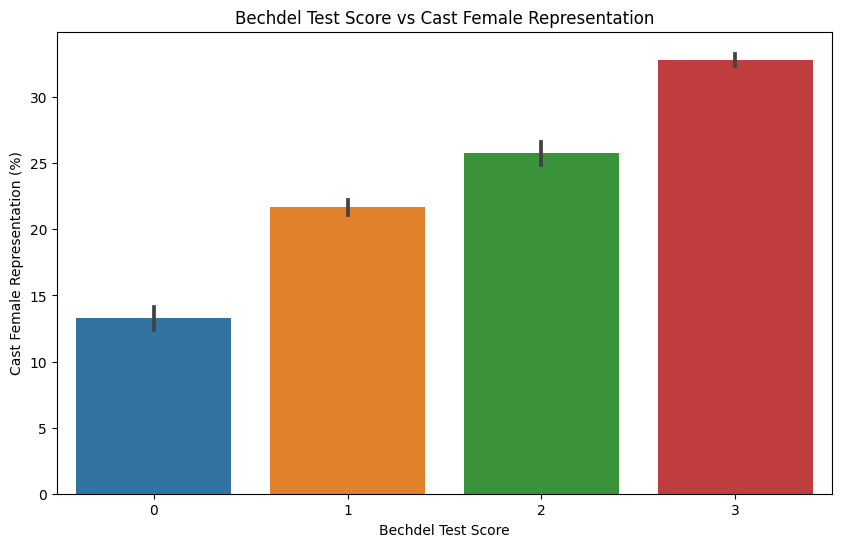

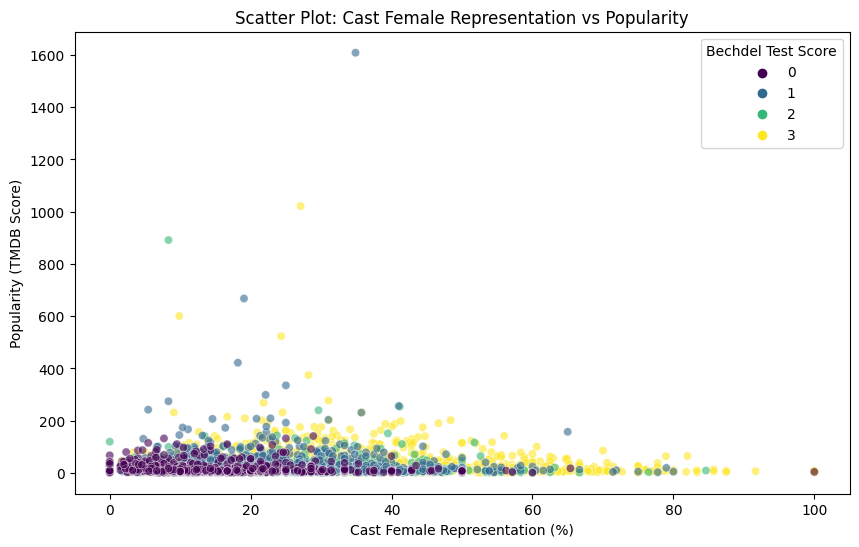

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns

# Bar chart visualization for bt_score and cast_female_representation
plt.figure(figsize=(10, 6))
sns.barplot(x='bt_score', y='cast_female_representation', data=df)
plt.title('Bechdel Test Score vs Cast Female Representation')
plt.xlabel('Bechdel Test Score')
plt.ylabel('Cast Female Representation (%)')
plt.show()

# Scatter plot visualization for cast female representation vs popularity
plt.figure(figsize=(10, 6))
sns.scatterplot(x='cast_female_representation', y='popularity', data=df, hue='bt_score', palette='viridis', alpha=0.6)
plt.title('Scatter Plot: Cast Female Representation vs Popularity')
plt.xlabel('Cast Female Representation (%)')
plt.ylabel('Popularity (TMDB Score)')
plt.legend(title='Bechdel Test Score')
plt.show()